In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports.py

In [3]:
ds = cifar10.CIFAR10()
# ds = mnist.MNIST()
net = cifar10.Network()

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# ds.calc_performance(net, tqdm=tqdm)

In [5]:
# import mnist

import torch
from torch import nn
import numpy as np
import util

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [6]:
from mnist import MNIST

In [7]:
def intercept(v1, g1, v2, g2):
    '''
    from: https://math.stackexchange.com/questions/1036959/midpoint-of-the-shortest-distance-between-2-rays-in-3d
    '''
    def dot(a, b):
        return (a*b).sum(dim=-1)
    
    a, b, c, d = v1, g1, v2, g2
    
    bd = dot(b, d)
    ad = dot(a, d)
    bc = dot(b, c)
    cd = dot(c, d) 
    ab = dot(a, b)
    
    s = (bd*(ad-bc)-ad*cd)/(bd**2.-1.)
    t = (bd*(cd-ad)-bc*ab)/(bd**2.-1.)
    
    return (a+c+b*t[:, None]+d*s[:, None])/2.

def intercept(v1, g1, v2, g2):
    '''
    from: https://math.stackexchange.com/questions/3242011/finding-the-closest-two-points-on-two-lines-in-n-dimensions
    '''
    
    bs = v1.shape[:-1]
    def dot(a, b):
        return (a*b).sum(dim=-1)
    
    g1 = g1/g1.norm(dim=-1, keepdim=True)
    g2 = g2/g2.norm(dim=-1, keepdim=True)
    
    a, b, c, d = v1, g1, v2, g2
    
    # Ax = B
    A = torch.zeros(*bs, 2, 2)
    B = torch.zeros(*bs, 2)
    A[..., 0, 0] = b.norm(dim=-1)**2.
    A[..., 0, 1] = -dot(b, d)
    A[..., 1, 0] = -dot(b, d)
    A[..., 1, 1] = d.norm(dim=-1)**2.
    
    
    B[..., 0] = -dot(a-c, b)
    B[..., 1] = dot(a-c, d)
    
#     print(A)
#     print(torch.matrix_rank(A))
#     print(A.det())
#     print(A.inverse())
    
    st = (A.inverse()@B[..., None])[..., 0]
    s, t = st[..., 0], st[..., 1]
    
    # TODO clip s, t to 0 as lower limit
    
#     if s<0 or t<0:
#         print('st ', s,t)
    
    return (a+c+b*s[..., None]+d*t[..., None])/2., s, t

In [8]:
from functions import *

In [9]:
def fn_quad(x):
    return x.norm(dim=-1)**2

def fg_fn(x, fn):
    x = x.detach().requires_grad_()
    loss = fn(x)
    loss.backward()
    return loss, x.grad

fn = rosenbrock

In [10]:
def calc_sgd_trajectory(x, steps, lr=1e-1):
    traj = [] # trajectory
    traj_grad = []

    x.requires_grad_()

    opt = torch.optim.SGD([x], lr=lr)
    for _ in range(steps):
        loss = fn(x)

        opt.zero_grad()
        loss.backward()
        traj.append(x.detach().clone())
        traj_grad.append(x.grad.detach().clone())
        opt.step()

    traj = torch.stack(traj)
    traj_grad = torch.stack(traj_grad)
    return traj, traj_grad

def calc_eps_intercept_trajectory(x, steps, eps=1e-1):
    traj = [] # trajectory
    traj_grad = []

    x1 = x
    
    for _ in range(steps):
        
        x2 = x1 + eps*torch.randn_like(x1)
        f1, g1 = fg_fn(x1, fn)
        f2, g2 = fg_fn(x2, fn)
        x3, _, _ = intercept(x1.detach(), -g1.detach(), x2.detach(), -g2.detach())
        
        traj.append(torch.stack([x1, x2]).detach().clone())
        traj_grad.append(torch.stack([g1, g2]).detach().clone())
        
        x1 = x3

    traj = torch.stack(traj)
    traj_grad = torch.stack(traj_grad)
    return traj, traj_grad

In [11]:
def plot_contour(fn, xmin, ymin, xmax, ymax):
    
    x1 = torch.linspace(xmin, xmax, 100)
    x2 = torch.linspace(ymin, ymax, 100)
    x1, x2 = torch.meshgrid(x1, x2)
    x = torch.stack([x1, x2], dim=-1)
    z = fn(x)

    plt.contourf(x1, x2, z, levels=100)
    plt.colorbar()

def plot_sgd_traj(traj, traj_grad, s=10, glen=.01):
    plt.scatter(*traj.T.numpy(), c='g', s=s)

    for v, g in zip(traj, traj_grad):
        a = torch.stack([v, v-glen*g])
        plt.plot(*a.numpy().T, c='r')
        
def plot_eps_intercept_traj(traj, traj_grad, s=10, glen=.01):
    plt.scatter(*traj[:, 0].T.numpy(), c='g', s=s)
    plt.scatter(*traj[:, 1].T.numpy(), c='b', s=s)

    for vs, gs in zip(traj, traj_grad):
        for v, g in zip(vs, gs):
            a = torch.stack([v, v-glen*g])
            plt.plot(*a.numpy().T, c='r')

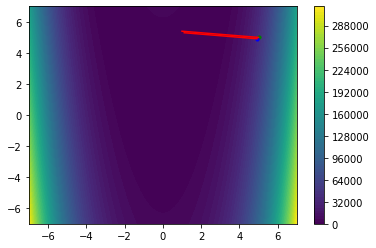

In [28]:

a = 7

x = torch.tensor([5., 5.])

# plot_contour(fn, -a, -a, a, a)
# traj, traj_grad = calc_sgd_trajectory(x, 10, lr=1e-6)
# plot_sgd_traj(traj, traj_grad, s=10, glen=1e-5)
# plt.show()

plot_contour(fn, -a, -a, a, a)
traj, traj_grad = calc_eps_intercept_trajectory(x, 2, eps=1e-1)
plot_eps_intercept_traj(traj, traj_grad, s=10, glen=1e-4)
plt.xlim(-a, a); plt.ylim(-a, a)
plt.show()

In [15]:
torch.manual_seed(1)
v1 = torch.randn(16, 2)
g1 = torch.randn(16, 2)
v2 = torch.randn(16, 2)
g2 = torch.randn(16, 2)

# v1 = torch.tensor([[0, 0.]])
# g1 = torch.tensor([[1, 0.]])
# v2 = torch.tensor([[0, -2.]])
# g2 = torch.tensor([[1, 2.]])/10.


In [16]:
it = intercept(v1, g1, v2, g2)

TypeError: scatter() got multiple values for argument 'marker'

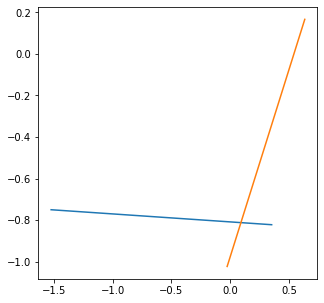

In [17]:

for i in range(len(v1)):
    plt.figure(figsize=(5, 5))
#     plt.quiver(*v1[i], *g1[i], scale=5)
#     plt.quiver(*v2[i], *g2[i], scale=5)
    
    plt.plot(*torch.stack([v1[i], v1[i]+g1[i]]).T)
    plt.plot(*torch.stack([v2[i], v2[i]+g2[i]]).T)
    plt.scatter(*it[i], marker='x', c='r', s=100)
    # plt.scatter(*it1[i], marker='x', c='g', s=100)

    plt.xlim(-4, 4); plt.ylim(-4, 4)
    plt.show()

In [12]:
def step_intercept_epsilon(x1, fn, eps=1e-2):
    x2 = x1 + eps*torch.randn_like(x1)
    f1, g1 = fg_fn(x1, fn)
    f2, g2 = fg_fn(x2, fn)
    x3 = intercept(x1.detach(), -g1.detach(), x2.detach(), -g2.detach())
    return x3

def step(x):
    fx = func(x)
    gx = grad(x)
    
    t = 1e-5
    while func(x-t*gx)<fx:
        t *= 2
    v1 = x-t/2.*gx
    v2 = x-t*gx
    v2 = v2+torch.randn_like(v2)*.1
    
    g1 = grad(v1)
    g2 = grad(v2)
    
    v3 = intercept(v1, -g1, v2, -g2)
    
    # plt.plot(*torch.stack([v1, (v1-g1/10.)]).T)
    # plt.plot(*torch.stack([v2, (v2-g2/10.)]).T)

    # plt.scatter(*v3, marker='x', c='r', s=100)
        

In [13]:
x1 = (torch.randn(100)*100).requires_grad_()
x2 = (torch.randn(2)*100).requires_grad_()

# f1, g1 = fg_quad(x1)
# f2, g2 = fg_quad(x2)

In [14]:
x1 = (torch.randn(100)).requires_grad_()
x3 = step_intercept_epsilon(x1, fn_quad, eps=1e-2)

# TODO the more parralel the two grad directions, the less you trust my intersection estimate
# use convex combination of (intersection estimate) and (mean of the two base points)

In [16]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(8, 8, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(8, 8, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 8, 3, padding=1),
            nn.MaxPool2d(3),
        )
        self.classification = nn.Sequential(
            nn.Linear(32, 10),
            nn.LogSoftmax(dim=-1),
        )
    def forward(self, x):
        x = self.seq(x)
        x = x.reshape(len(x), -1)
        x = self.classification(x)
        return x

In [18]:
ds = mnist.MNIST()
dataset = mnist

ds = cifar10.CIFAR10()
dataset = cifar10

Files already downloaded and verified
Files already downloaded and verified


In [19]:
net = dataset.Network()
opt = torch.optim.Adam(net.parameters(), lr=1e-2)
print(np.sum([p.numel() for p in net.parameters()]))

# net(torch.randn(1,1,28,28))

v = nn.utils.parameters_to_vector(net.parameters()).detach().requires_grad_()

2306


In [31]:
data = {}

## MNIST Adam

In [193]:
torch.manual_seed(0)
net = dataset.Network()
opt = torch.optim.Adam(net.parameters(), lr=1e-2)

accu = util.Accumulator()

for epoch_idx in range(10):
    for x, y in tqdm(ds.dl_train):
        yp = net(x)
        loss = ds.loss_fn(yp, y)
        acc = (yp.argmax(dim=-1)==y).sum().item()/len(x)

        opt.zero_grad()
        loss.backward()
        w = torch.cat([p.flatten().detach() for p in net.parameters()])
        wg = torch.cat([p.grad.flatten().detach() for p in net.parameters()])
        opt.step()
        
        wnorm = nn.utils.parameters_to_vector(net.parameters()).norm()
        
        accu.append(loss_batch=loss.item(), acc_batch=acc, wnorm=wnorm.item(), w=w.numpy(), wg=wg.numpy())
        
data['adam'] = accu

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [202]:
w_opt = torch.from_numpy(accu['w'][-1])

In [217]:
noise = []
losses = []
for x, y in tqdm(ds.dl_train):
    eps = torch.randn(1).exp()*torch.randn_like(w_opt)
    w = eps+w_opt
    wnorm = nn.utils.parameters_to_vector(net.parameters()).norm()
    nn.utils.vector_to_parameters(w, net.parameters())
    yp = net(x)
    loss = ds.loss_fn(yp, y)
    noise.append(eps.norm().item())
    losses.append(loss.item())
noise = torch.tensor(noise)
losses = torch.tensor(losses)

  0%|          | 0/50 [00:00<?, ?it/s]

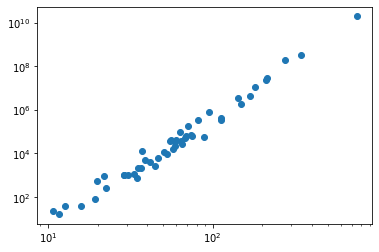

In [219]:
plt.scatter(noise, losses)
plt.xscale('log')
plt.yscale('log')

In [444]:
w = torch.from_numpy(accu['w'])
wg = torch.from_numpy(accu['wg'])
w_opt = w[-1]

In [445]:

def calc_loss_grad(w):
    x, y = next(iter(ds.dl_train))
    nn.utils.vector_to_parameters(w, net.parameters())
    yp = net(x)
    loss = ds.loss_fn(yp, y)
    opt.zero_grad()
    loss.backward()
    return loss.item(), torch.cat([p.grad.flatten().detach() for p in net.parameters()])

In [446]:
loss, g = calc_loss_grad(w[0])
print(loss, g.abs().mean(), g)

2.3053641319274902 tensor(0.0004) tensor([-7.0633e-05,  7.7751e-05, -1.4290e-04,  ...,  1.4163e-02,
        -1.6070e-02,  6.0816e-03])


In [447]:
loss, g = calc_loss_grad(w[-1])
print(loss, g.abs().mean(), g)

1.280420184135437 tensor(0.0282) tensor([ 0.0315,  0.0406,  0.0264,  ..., -0.0025,  0.0205,  0.0014])


In [729]:
a = w[30]
# b = a+1e-2*-wg[30]
b = a+3.*(w[31]-a)

In [721]:
temp = np.array([calc_loss_grad(a)[0] for _ in tqdm(range(50))])
print(temp.mean()-temp.std(), temp.mean(), temp.mean()+temp.std())

  0%|          | 0/50 [00:00<?, ?it/s]

1.9774254330182268 1.9975853085517883 2.0177451840853498


In [722]:
for i in range(5):
    temp = np.array([calc_loss_grad(w[30+i])[0] for _ in tqdm(range(20))])
    print(temp.mean()-temp.std(), temp.mean(), temp.mean()+temp.std())

  0%|          | 0/20 [00:00<?, ?it/s]

1.9700348463181045 1.9931335031986237 2.016232160079143


  0%|          | 0/20 [00:00<?, ?it/s]

1.9681223449958314 1.9887425899505615 2.009362834905292


  0%|          | 0/20 [00:00<?, ?it/s]

1.9552130600634972 1.9830652475357056 2.0109174350079138


  0%|          | 0/20 [00:00<?, ?it/s]

1.9476587615547531 1.972130012512207 1.9966012634696608


  0%|          | 0/20 [00:00<?, ?it/s]

1.9322340289027287 1.9592256247997284 1.9862172206967281


In [744]:
# torch.manual_seed(1)
la, ga = calc_loss_grad(a)
# torch.manual_seed(1)
lb, gb = calc_loss_grad(b)

In [745]:
la, lb

(1.9633780717849731, 2.0633890628814697)

In [725]:
ga, gb

(tensor([ 0.0064,  0.0067,  0.0034,  ...,  0.0102, -0.0131,  0.0185]),
 tensor([-0.0004, -0.0132, -0.0276,  ...,  0.0037,  0.0201,  0.0337]))

In [726]:
a, b

(tensor([-0.1885, -0.0331, -0.0825,  ...,  0.0186, -0.1911, -0.2560]),
 tensor([-0.2095, -0.0467, -0.0828,  ...,  0.0062, -0.1914, -0.2693]))

In [727]:
def interpolate_weight_grad(a, ga, b, gb, avg=False):
    mask1 = torch.logical_and(-ga>0, -gb<0)
    mask1 = torch.logical_and(a<b, mask1)
    mask2 = torch.logical_and(-gb>0, -ga<0)
    mask2 = torch.logical_and(b<a, mask2)
    mask = torch.logical_or(mask1, mask2)
    # mask = mask1
    print(mask.sum())
    c = a.clone()
    
    if avg:
        c[mask] = (a[mask]+b[mask])/2.
    else:
        ta = ga[mask].abs()
        tb = gb[mask].abs()
        z = ta+tb
        c[mask] = tb/z*a[mask]+ta/z*b[mask]
    return c, mask

In [728]:
c, mask = interpolate_weight_grad(a, ga, b, gb, avg=True)
torch.manual_seed(0)
temp = np.array([calc_loss_grad(c)[0] for _ in tqdm(range(50))])
print(temp.mean()-temp.std(), temp.mean(), temp.mean()+temp.std())
torch.manual_seed(0)
c, mask = interpolate_weight_grad(a, ga, b, gb, avg=False)
temp = np.array([calc_loss_grad(c)[0] for _ in tqdm(range(50))])
print(temp.mean()-temp.std(), temp.mean(), temp.mean()+temp.std())

tensor(462)


  0%|          | 0/50 [00:00<?, ?it/s]

1.9580971010091537 1.9792889404296874 2.000480779850221
tensor(462)


  0%|          | 0/50 [00:00<?, ?it/s]

1.9593507528120728 1.980455641746521 2.001560530680969


# Learned Lessons

So basically, I think the extrapolative intercept thing works better than SGD, its just that the learning rate does not adapt fast enough like in Adam.
(Adam takes multiple 1e-5 gradients and bumps up the LR a lot for that weight and takes it to parts of weight space where gradients are not that low)

Another thing I can do to improve ON TOP OF Adam is to, rather than find the best LR adaptation, 
we can "overshoot" the optimum weight and get a (weight, gradient) pair on the "other side" of the optimum.
Then we can teleport some parts of the weight to that optimum knowing the two pairs.

In [283]:
# w_opt-wn, w_opt-w

In [180]:
ws, wgs = [], []
for x, y in tqdm(ds.dl_train):
    yp = net(x)
    loss = ds.loss_fn(yp, y)
    opt.zero_grad()
    loss.backward()
    w = torch.cat([p.flatten().detach() for p in net.parameters()])
    wg = torch.cat([p.grad.flatten().detach() for p in net.parameters()])
    ws.append(w)
    wgs.append(wg)
ws = torch.stack(ws)
wgs = torch.stack(wgs)

  0%|          | 0/50 [00:00<?, ?it/s]

In [113]:
import sklearn.manifold

In [114]:
tsne = sklearn.manifold.TSNE()
x = tsne.fit_transform(ws.numpy())


/Users/akarshkumar0101/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/akarshkumar0101/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [115]:
x.shape

(500, 2)

In [117]:
x[0], x[250]

(array([ 22.921944, -16.453672], dtype=float32),
 array([ 22.634884, -16.115044], dtype=float32))

In [118]:
ws[0], ws[250]

(tensor([-0.0014,  0.1032, -0.1584,  ...,  0.1078, -0.1675, -0.1584]),
 tensor([-0.0014,  0.1032, -0.1584,  ...,  0.1078, -0.1675, -0.1584]))

In [125]:
ws.shape

torch.Size([500, 2306])

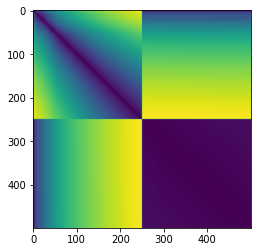

In [135]:
plt.imshow((ws[:, None, :]-ws[None, :, :]).norm(dim=-1).numpy())

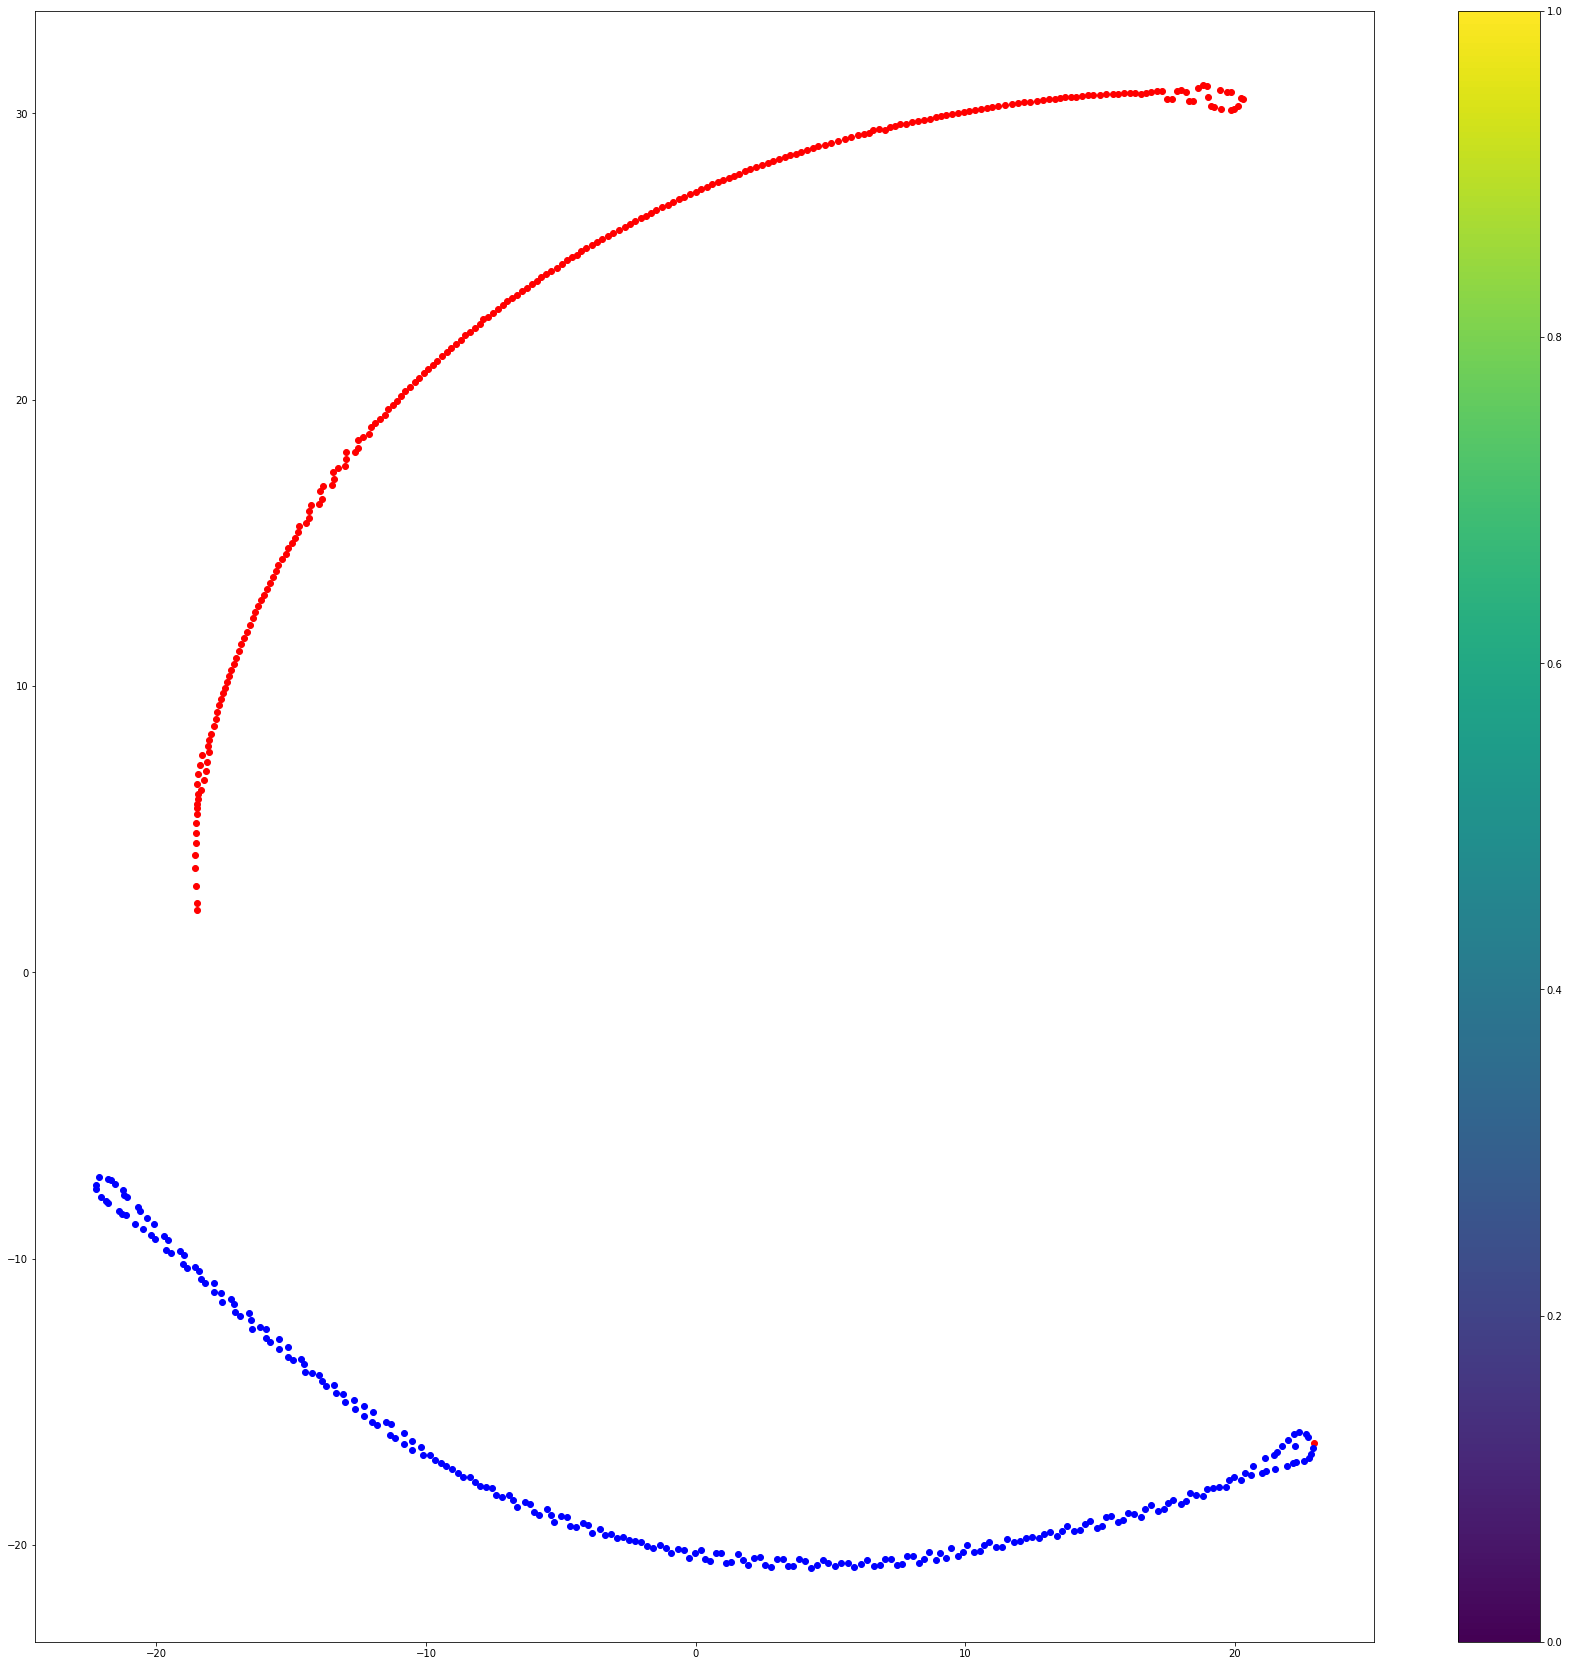

In [121]:
plt.figure(figsize=(30,30))
# plt.scatter(*x.T, c=accu['loss_batch'])
plt.scatter(*x[:250].T, c='r')
plt.scatter(*x[250:].T, c='b')
# plt.plot(*x.T)
plt.colorbar()

## MNIST SGD w/ Momentum

In [132]:
torch.manual_seed(0)
net = dataset.Network()
opt = torch.optim.SGD(net.parameters(), lr=1e-1, momentum=0.9)

accu = util.Accumulator()

for epoch_idx in range(1):
    for x, y in tqdm(ds.dl_train):
        yp = net(x)
        loss = ds.loss_fn(yp, y)
        acc = (yp.argmax(dim=-1)==y).sum().item()/len(x)

        opt.zero_grad()
        loss.backward()
        w = torch.cat([p.flatten().detach() for p in net.parameters()])
        wg = torch.cat([p.grad.flatten().detach() for p in net.parameters()])
        opt.step()

        wnorm = nn.utils.parameters_to_vector(net.parameters()).norm()
        
        accu.append(loss_batch=loss.item(), acc_batch=acc, wnorm=wnorm.item(), w=w.numpy(), wg=wg.numpy())
        
data['sgdm'] = accu

  0%|          | 0/50 [00:00<?, ?it/s]

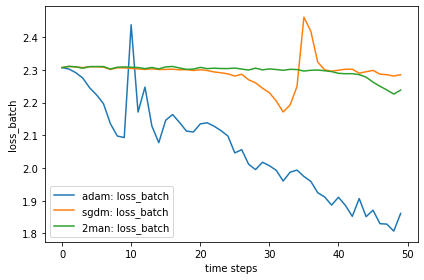

In [133]:
util.plot_accumulators(data, keys=['loss_batch'])

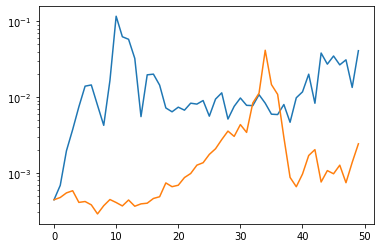

In [136]:
a = torch.from_numpy(data['adam']['wg'])
plt.plot(a.abs().mean(dim=-1).numpy())
a = torch.from_numpy(data['sgdm']['wg'])
plt.plot(a.abs().mean(dim=-1).numpy())
plt.yscale('log')

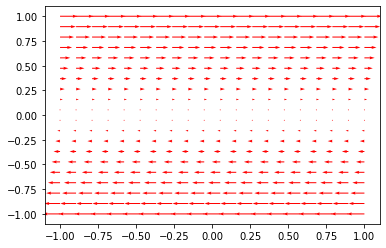

In [172]:
x = np.linspace(-1, 1, 20)
y = np.linspace(-1, 1, 20)
x, y = np.meshgrid(x, y, indexing='ij')

plt.quiver(x, y, y, np.zeros_like(x), color='r')

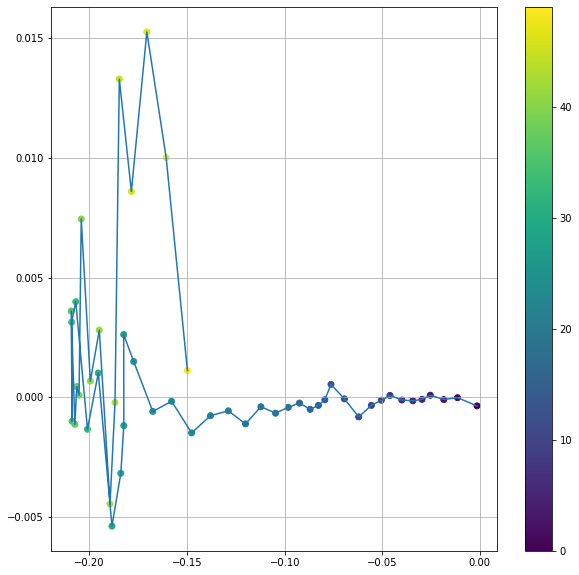

In [161]:
w = torch.from_numpy(data['adam']['w'])
wg = torch.from_numpy(data['adam']['wg'])

plt.figure(figsize=(10,10))
i = 0
plt.scatter(w[:, i], -wg[:, i], c=np.arange(50))
plt.plot(w[:, i], -wg[:, i])
plt.grid()
plt.colorbar()

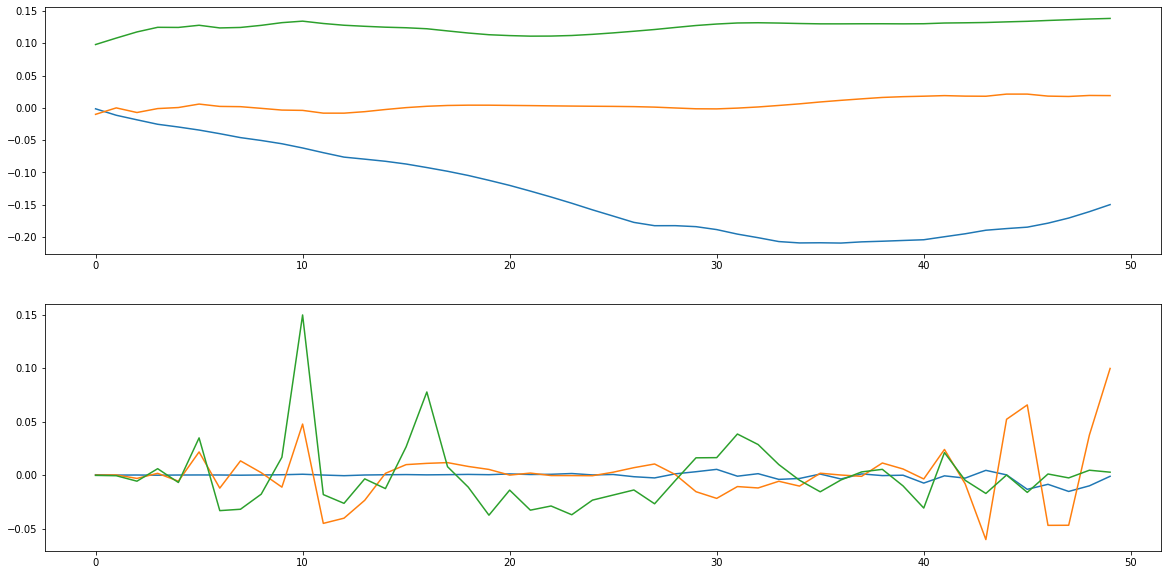

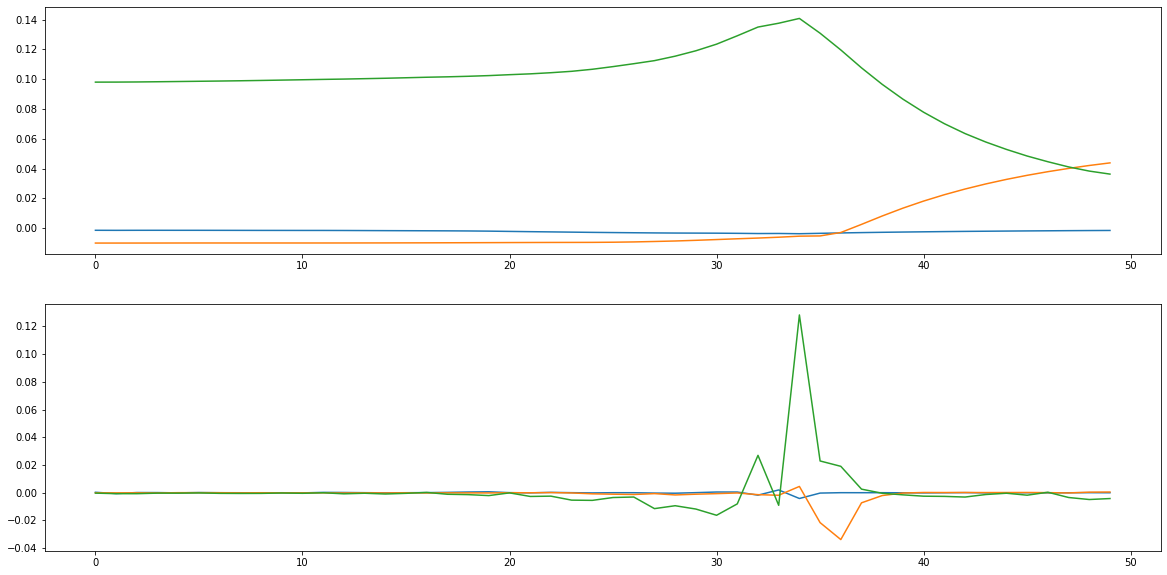

In [135]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(data['adam']['w'][:, ::1000])
plt.subplot(212)
plt.plot(data['adam']['wg'][:, ::1000], linestyle='-')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(data['sgdm']['w'][:, ::1000])
plt.subplot(212)
plt.plot(data['sgdm']['wg'][:, ::1000], linestyle='-')
plt.show()

In [256]:
vo = nn.utils.parameters_to_vector(net.parameters()).detach().requires_grad_()

In [257]:
fo, g = fg_fn_nn(vo, x, y)
fs = []

for t in tqdm(torch.logspace(-1, -3, 20)):
    f, _ = fg_fn_nn(vo+g*t, x, y)
    fs.append([t,f.item()])
fs.append([0, fo.item()])
for t in tqdm(-torch.logspace(-3, -1, 20)):
    f, _ = fg_fn_nn(vo+g*t, x, y)
    fs.append([t, f.item()])
fs = np.array(fs)

100%|██████████| 20/20 [00:03<00:00,  5.08it/s]


(0.1917508840560913, 3.0)

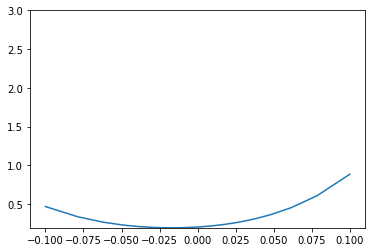

In [258]:
plt.plot(*fs.T)
plt.ylim(fs[:, 1].min(), 3)
# plt.xscale('symlog')

In [34]:
def step_epsilon(x1, x, y, net, opt, eps=1e-2):
    f1, g1 = fg_fn_nn(x1, x, y, net, opt)
    
    g1n = g1/g1.norm(dim=-1, keepdim=True)
    x2 = x1 + eps*torch.randn_like(x1)-g1n*eps

    f2, g2 = fg_fn_nn(x2, x, y, net, opt)
    x3, s, t = intercept(x1.detach(), -g1.detach(), x2.detach(), -g2.detach())
    return f1, x3, s, t

def step_smart(x1, x, y, t=1e-5):
    f1, g1 = fg_fn_nn(x1, x, y)
    
    ft, gt = fg_fn_nn(x1-t*g1, x, y)
    if ft<f1:
        while ft<f1:
            t *= 2.
            ft, gt = fg_fn_nn(x1-t*g1, x, y)
    elif ft>f1:
        while ft>f1:
            t /= 2.
            ft, gt = fg_fn_nn(x1-t*g1, x, y)
        t*=2.
        
    x2 = x1-t*g1
    x1 = x1-t/2.*g1
    
    f1, g1 = fg_fn_nn(x1, x, y)
    f2, g2 = fg_fn_nn(x2, x, y)
    x3 = intercept(x1.detach(), -g1.detach(), x2.detach(), -g2.detach())
    return f1, x3

In [35]:
def fg_fn_nn(v, x, y, net, opt):
    nn.utils.vector_to_parameters(v, net.parameters())
    opt.zero_grad()
    yp = net(x)
    loss = ds.loss_fn(yp, y)
    loss.backward()
    
    g = torch.cat([p.grad.flatten() for p in net.parameters()])
    return loss, g

## MNIST Two-Man-SGD

In [57]:
torch.manual_seed(0)
net = dataset.Network()
opt = torch.optim.Adam(net.parameters(), lr=1e-2)
v = nn.utils.parameters_to_vector(net.parameters()).detach().requires_grad_()

accu = util.Accumulator()

eps = 1e-3

for epoch_idx in range(1):
    for x, y in tqdm(ds.dl_train):
        f1, v2, s, t = step_epsilon(v, x, y, net, opt, eps)
        step_size = 0.
        
        # if 'step_size' in accu.keys() and (v2-v).norm()>accu['step_size'].mean()+accu['step_size'].std():
            # continue
        
        pv = v
        if s>0 and t>0:
            print(f'step size {(v2-v).norm():.04f}')
            step_size = (v2-v).norm().item()
            v = v2
        
        
        # f1, v = step_smart(v, x, y)
        # print('mean abs weight ', x1.abs().mean().item())
        
        w = nn.utils.parameters_to_vector(net.parameters()).detach()
        yp = net(x)
        loss = ds.loss_fn(yp, y)
        acc = (yp.argmax(dim=-1)==y).sum().item()/len(x)
        print(f'{loss.item(): .03f}, {v.norm(dim=-1): .03f}')
        
        if 'loss_batch' in accu.keys() and loss.item()>accu['loss_batch'][-1].item():
            # goback
            v = pv

        
        if 'loss_batch' in accu.keys() and loss.item()>accu['loss_batch'][-1]+.2:
            print('DETECTED SPIKE')
            for i, (x, y) in enumerate(ds.dl_train):
                yp = net(x)
                loss = ds.loss_fn(yp, y)
                print(loss.item())
                if i==5:
                    break
            print('\n\n\n\n')
        
        wnorm = nn.utils.parameters_to_vector(net.parameters()).norm()
        accu.append(loss_batch=loss.item(), acc_batch=acc, wnorm=wnorm.item(), 
                    step_size=step_size, w=w.numpy())
        
data['2man'] = accu

  0%|          | 0/50 [00:00<?, ?it/s]

step size 0.0236
 2.307,  3.772
step size 0.0378
 2.310,  3.770
step size 0.0648
 2.309,  3.770
 2.305,  3.770
step size 0.0353
 2.310,  3.769
 2.310,  3.770
step size 0.0310
 2.310,  3.770
step size 0.0327
 2.302,  3.770
step size 0.0424
 2.308,  3.768
 2.309,  3.770
step size 0.0257
 2.308,  3.769
step size 0.0342
 2.307,  3.767
 2.304,  3.767
step size 0.0372
 2.307,  3.765
step size 0.0339
 2.303,  3.767
step size 0.0485
 2.309,  3.766
step size 0.0457
 2.310,  3.766
step size 0.0527
 2.306,  3.765
step size 0.0242
 2.301,  3.765
step size 0.0418
 2.302,  3.767
step size 0.0252
 2.307,  3.765
step size 0.0361
 2.304,  3.766
step size 0.0282
 2.305,  3.766
step size 0.0248
 2.304,  3.766
step size 0.0478
 2.304,  3.767
 2.305,  3.767
step size 0.0452
 2.302,  3.768
 2.299,  3.768
step size 0.0386
 2.305,  3.769
step size 0.0517
 2.300,  3.771
step size 0.0255
 2.303,  3.771
step size 0.0312
 2.301,  3.772
 2.298,  3.772
 2.301,  3.772
step size 0.0290
 2.301,  3.774
step size 0.0578

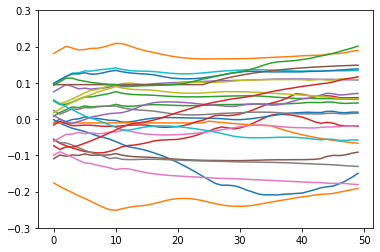

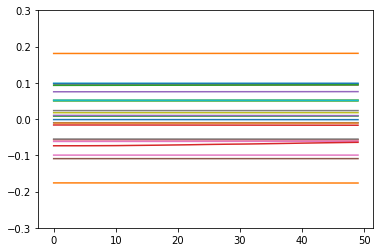

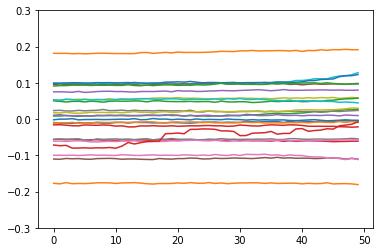

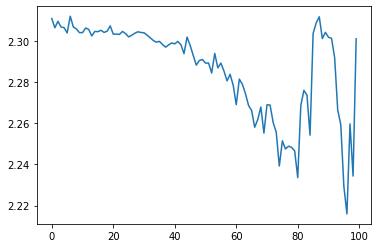

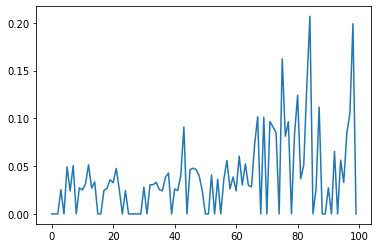

In [146]:
plt.plot(accu['loss_batch'])
plt.show()
plt.plot(accu['step_size'])

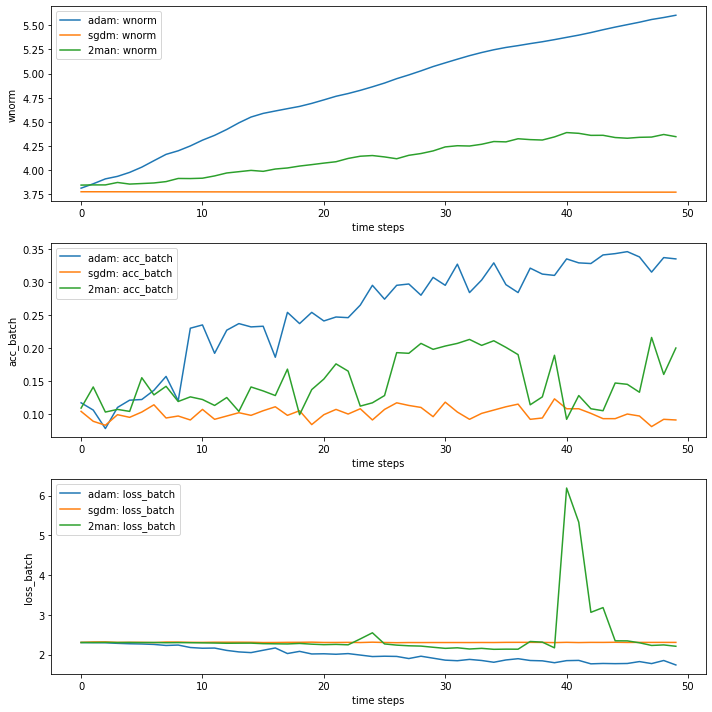

In [117]:
plt.figure(figsize=(10,10))
util.plot_accumulators(data)

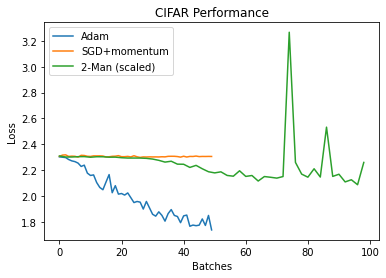

In [107]:
plt.plot(data['adam']['loss_batch'], label='Adam')
plt.plot(data['sgdm']['loss_batch'], label='SGD+momentum')
plt.plot(np.arange(len(data['2man']['loss_batch']))*2, 
         data['2man']['loss_batch'], label='2-Man (scaled)')
plt.title('CIFAR Performance'); plt.ylabel('Loss'); plt.xlabel('Batches')
plt.legend()

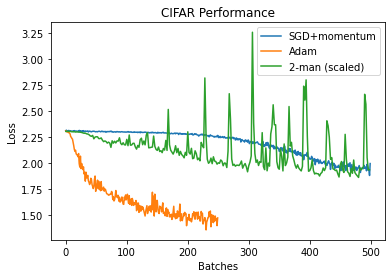

In [40]:
plt.plot(np.array(data['sgdm_meter_loss'].data)[:, 0], label='SGD+momentum')
plt.plot(np.array(data['adam_meter_loss'].data)[:, 0], label='Adam')
plt.plot(np.arange(250)*2, np.array(data['2mansgd_meter_loss'].data)[:, 0], label='2-man (scaled)')
plt.title('CIFAR Performance'); plt.ylabel('Loss'); plt.xlabel('Batches')
plt.legend()

# Combining Adam/SGD with momentum to the gradients (delta weights) for 2 man sgd

In [50]:
np.sum([p.numel() for p in net.parameters()])

2306

In [56]:
def set_grad(g, net):
    i = 0
    for p in net.parameters():
        if g is None:
            p.data = None
        else:
            gdata = g[i: i+p.numel()].reshape(p.shape)
            p.grad = gdata.clone()
    
set_grad(torch.zeros(2306), net)

In [60]:
net = dataset.Network()
# opt = torch.optim.Adam(net.parameters(), lr=1e-2)
opt = torch.optim.SGD(net.parameters(), lr=1, momentum=0.9)
# opt = torch.optim.SGD(net.parameters(), lr=1, momentum=0)
v = nn.utils.parameters_to_vector(net.parameters()).detach().requires_grad_()

meter_acc = metrics.AverageMeter(keep_verbose_stats=True)
meter_loss = metrics.AverageMeter(keep_verbose_stats=True)

eps = 1e-2

for epoch_idx in range(5):
    for x, y in tqdm(ds.dl_train):
        f1, v2, s, t = step_epsilon(v, x, y, net, opt, eps)
        nv = v
        if s>0 and t>0:
            nv = v2
        g = -(nv-v)
        
        set_grad(g, net)
        opt.step()
        opt.zero_grad()
        
        
        
        
        yp = net(x)
        loss = ds.loss_fn(yp, y)
        acc = (yp.argmax(dim=-1)==y).sum().item()/len(x)
        print(loss.item())

        meter_acc.update(acc, len(x))
        meter_loss.update(loss.item(), len(x))
    
data['2mansgd_meter_loss'] = meter_loss
data['2mansgd_meter_acc'] = meter_acc

  0%|          | 0/50 [00:00<?, ?it/s]

2.3124072551727295
2.305079698562622
2.300426959991455
2.3082163333892822
2.3035242557525635
2.30521821975708
2.3046319484710693
2.300846815109253
2.307983875274658
2.3099865913391113
2.3053438663482666
2.3066904544830322
2.3061087131500244
2.2977609634399414
2.299973726272583
2.3055291175842285


KeyboardInterrupt: 

# TODO: sample noise not randomly, but towards negative grad

# TODO: ignore intersection if line s or t values are negative
# (this means go away from the negative grad)